# Anomaly Detection in Multivariate Time-Series Forecasting using Facebook (Meta) Prophet

Setting Up the Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!python -m pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import plotly.express as px
from prophet import Prophet

Dataset

In [ ]:
#add location of the dataset
file_path = "/content/drive/MyDrive/Real Ad Exchange Dataset/realAdExchange/exchange-2_cpc_results.csv"

In [ ]:
df = pd.read_csv(file_path)
df

,timestamp,value
0,2011-07-01 00:00:01,0.081965
1,2011-07-01 01:00:01,0.098972
2,2011-07-01 02:00:01,0.065314
3,2011-07-01 03:00:01,0.070663
4,2011-07-01 04:00:01,0.102490
...,...,...
1619,2011-09-07 11:00:01,0.094662
1620,2011-09-07 12:00:01,0.097657
1621,2011-09-07 13:00:01,0.096201
1622,2011-09-07 14:00:01,0.085386


In [ ]:
df.shape

(1624, 2)

Data Preprocessing

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index(['timestamp'], inplace=True)
df.head()

,value
timestamp,
2011-07-01 00:00:01,0.081965
2011-07-01 01:00:01,0.098972
2011-07-01 02:00:01,0.065314
2011-07-01 03:00:01,0.070663
2011-07-01 04:00:01,0.102490


Feature Engineering (to generate more variables to be considered as factors affecting the model - Multivariate)

In [ ]:
# Resampling the timeseries to hourly basis 
df_hourly = df.resample('H').mean()

# Creating features from date
df_hourly['day'] = [i.day for i in df_hourly.index]
df_hourly['day_name'] = [i.day_name() for i in df_hourly.index]
df_hourly['day_of_year'] = [i.dayofyear for i in df_hourly.index]
df_hourly['week_of_year'] = [i.weekofyear for i in df_hourly.index]
df_hourly['hour'] = [i.hour for i in df_hourly.index]
df_hourly['is_weekday'] = [i.isoweekday() for i in df_hourly.index]
df_hourly.head()

,value,day,day_name,day_of_year,week_of_year,hour,is_weekday
timestamp,,,,,,,
2011-07-01 00:00:00,0.081965,1,Friday,182,26,0,5
2011-07-01 01:00:00,0.098972,1,Friday,182,26,1,5
2011-07-01 02:00:00,0.065314,1,Friday,182,26,2,5
2011-07-01 03:00:00,0.070663,1,Friday,182,26,3,5
2011-07-01 04:00:00,0.102490,1,Friday,182,26,4,5


In [ ]:
df_final = df_hourly.reset_index()[['timestamp', 'value', 'day', 'day_name', 'day_of_year', 'week_of_year', 'hour', 'is_weekday']].rename({'timestamp':'ds', 'value':'y', 'day':'day', 'day_of_year':'day_of_year',  'week_of_year':'week_of_year', 'hour':'hour', 'is_weekday':'is_weekday'}, axis = 'columns')
df_final

,ds,y,day,day_name,day_of_year,week_of_year,hour,is_weekday
0,2011-07-01 00:00:00,0.081965,1,Friday,182,26,0,5
1,2011-07-01 01:00:00,0.098972,1,Friday,182,26,1,5
2,2011-07-01 02:00:00,0.065314,1,Friday,182,26,2,5
3,2011-07-01 03:00:00,0.070663,1,Friday,182,26,3,5
4,2011-07-01 04:00:00,0.102490,1,Friday,182,26,4,5
...,...,...,...,...,...,...,...,...
1643,2011-09-07 11:00:00,0.094662,7,Wednesday,250,36,11,3
1644,2011-09-07 12:00:00,0.097657,7,Wednesday,250,36,12,3
1645,2011-09-07 13:00:00,0.096201,7,Wednesday,250,36,13,3
1646,2011-09-07 14:00:00,0.085386,7,Wednesday,250,36,14,3


In [ ]:
# Facebook Prophet takes care of the missing values in the Target Column, but does not look after the missing values in the other variable columns.
# In this case all columns except ds & y.
# Hence we ourselves check for missing values in the other columns i.e. NaN.
df_final.query('day != day')
df_final.query('day_name != day_name')
df_final.query('day_of_year	 != day_of_year	')
df_final.query('week_of_year != week_of_year')
df_final.query('hour != hour')
df_final.query('is_weekday != is_weekday')

# Here no missing values were found.

,ds,y,day,day_name,day_of_year,week_of_year,hour,is_weekday


In [ ]:
# Using the fillna() method from pandas, we will 'forward fill' i.e. ffill the Missing Value
df_final = df_final.fillna(method = 'ffill')

# Nothing was forward filled, since no missing values were found.

In [ ]:
# Adding a month column to the dataframe, which will give the number of the particular month
df_final['month'] = df_final['ds'].dt.month

In [ ]:
df_final.head()

,ds,y,day,day_name,day_of_year,week_of_year,hour,is_weekday,month
0,2011-07-01 00:00:00,0.081965,1,Friday,182,26,0,5,7
1,2011-07-01 01:00:00,0.098972,1,Friday,182,26,1,5,7
2,2011-07-01 02:00:00,0.065314,1,Friday,182,26,2,5,7
3,2011-07-01 03:00:00,0.070663,1,Friday,182,26,3,5,7
4,2011-07-01 04:00:00,0.102490,1,Friday,182,26,4,5,7


In [ ]:
df_final

,ds,y,day,day_name,day_of_year,week_of_year,hour,is_weekday,month
0,2011-07-01 00:00:00,0.081965,1,Friday,182,26,0,5,7
1,2011-07-01 01:00:00,0.098972,1,Friday,182,26,1,5,7
2,2011-07-01 02:00:00,0.065314,1,Friday,182,26,2,5,7
3,2011-07-01 03:00:00,0.070663,1,Friday,182,26,3,5,7
4,2011-07-01 04:00:00,0.102490,1,Friday,182,26,4,5,7
...,...,...,...,...,...,...,...,...,...
1643,2011-09-07 11:00:00,0.094662,7,Wednesday,250,36,11,3,9
1644,2011-09-07 12:00:00,0.097657,7,Wednesday,250,36,12,3,9
1645,2011-09-07 13:00:00,0.096201,7,Wednesday,250,36,13,3,9
1646,2011-09-07 14:00:00,0.085386,7,Wednesday,250,36,14,3,9


Data Visualization

In [ ]:
# Visualing the data using plotly
fig = px.line(df_final, x='ds', y='y', hover_data=['day', 'day_name', 'day_of_year', 'week_of_year', 'hour', 'is_weekday', 'month'], title='Real Ad Exchange')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector = dict(
        buttons=list([
                      dict(count=1, label="1y", step="year", stepmode="backward"),
                      dict(count=2, label="3y", step="year", stepmode="backward"),
                      dict(count=3, label="5y", step="year", stepmode="backward"),
                      dict(step="all")
        ])
    )
)

fig.show()

In [ ]:
# Checking the Maximum, Minimum, and Average value of 'y' for each hour of the day
df_final[['hour', 'y']].groupby('hour').agg({'y':{'max', 'min', 'mean'}})

y                    
           min      mean       max
hour                              
0     0.040555  0.076766  0.126895
1     0.036329  0.070469  0.115210
2     0.029836  0.062447  0.104638
3     0.026843  0.055901  0.104638
4     0.039034  0.072798  0.136761
5     0.051258  0.091418  0.161497
6     0.049853  0.099622  0.183986
7     0.061923  0.121641  0.191602
8     0.104638  0.159612  0.218536
9     0.098608  0.141139  0.226598
10    0.093615  0.127746  0.181725
11    0.094026  0.122838  0.159902
12    0.089616  0.122931  0.176341
13    0.079773  0.124328  0.190700
14    0.074123  0.126643  0.207095
15    0.068836  0.123101  0.172836
16    0.060932  0.112077  0.166081
17    0.051182  0.101218  0.145224
18    0.058831  0.095511  0.149355
19    0.055302  0.092093  0.145936
20    0.050912  0.088118  0.165860
21    0.048883  0.086464  0.171937
22    0.044633  0.086494  0.183754
23    0.043706  0.083055  0.173424

In [ ]:
def abnormal_values_of_y_based_on_hourly_analysis(y):
  if y > 0.19 or y < 0.05:
    return 1
  else:
    return 0

In [ ]:
# If value is outside the range 0.05-0.19, it will be regarded as 1
df_final['hourly_analysis'] = df_final['y'].apply(abnormal_values_of_y_based_on_hourly_analysis)

In [ ]:
df_final

,ds,y,day,day_name,day_of_year,week_of_year,hour,is_weekday,month,hourly_analysis
0,2011-07-01 00:00:00,0.081965,1,Friday,182,26,0,5,7,0
1,2011-07-01 01:00:00,0.098972,1,Friday,182,26,1,5,7,0
2,2011-07-01 02:00:00,0.065314,1,Friday,182,26,2,5,7,0
3,2011-07-01 03:00:00,0.070663,1,Friday,182,26,3,5,7,0
4,2011-07-01 04:00:00,0.102490,1,Friday,182,26,4,5,7,0
...,...,...,...,...,...,...,...,...,...,...
1643,2011-09-07 11:00:00,0.094662,7,Wednesday,250,36,11,3,9,0
1644,2011-09-07 12:00:00,0.097657,7,Wednesday,250,36,12,3,9,0
1645,2011-09-07 13:00:00,0.096201,7,Wednesday,250,36,13,3,9,0
1646,2011-09-07 14:00:00,0.085386,7,Wednesday,250,36,14,3,9,0


Splitting the Data into 'Train' & 'Test'

In [ ]:
train = df_final[(df_final['ds'] >= '2011-07-01') & (df_final['ds'] <= '2011-08-31')]
test = df_final[(df_final['ds'] > '2011-08-31')]

In [ ]:
train.shape

(1465, 10)

In [ ]:
train

,ds,y,day,day_name,day_of_year,week_of_year,hour,is_weekday,month,hourly_analysis
0,2011-07-01 00:00:00,0.081965,1,Friday,182,26,0,5,7,0
1,2011-07-01 01:00:00,0.098972,1,Friday,182,26,1,5,7,0
2,2011-07-01 02:00:00,0.065314,1,Friday,182,26,2,5,7,0
3,2011-07-01 03:00:00,0.070663,1,Friday,182,26,3,5,7,0
4,2011-07-01 04:00:00,0.102490,1,Friday,182,26,4,5,7,0
...,...,...,...,...,...,...,...,...,...,...
1460,2011-08-30 20:00:00,0.075349,30,Tuesday,242,35,20,2,8,0
1461,2011-08-30 21:00:00,0.065388,30,Tuesday,242,35,21,2,8,0
1462,2011-08-30 22:00:00,0.089247,30,Tuesday,242,35,22,2,8,0
1463,2011-08-30 23:00:00,0.081306,30,Tuesday,242,35,23,2,8,0


In [ ]:
test.shape

(183, 10)

In [ ]:
test

,ds,y,day,day_name,day_of_year,week_of_year,hour,is_weekday,month,hourly_analysis
1465,2011-08-31 01:00:00,0.079748,31,Wednesday,243,35,1,3,8,0
1466,2011-08-31 02:00:00,0.066393,31,Wednesday,243,35,2,3,8,0
1467,2011-08-31 03:00:00,0.064618,31,Wednesday,243,35,3,3,8,0
1468,2011-08-31 04:00:00,0.087396,31,Wednesday,243,35,4,3,8,0
1469,2011-08-31 05:00:00,0.109590,31,Wednesday,243,35,5,3,8,0
...,...,...,...,...,...,...,...,...,...,...
1643,2011-09-07 11:00:00,0.094662,7,Wednesday,250,36,11,3,9,0
1644,2011-09-07 12:00:00,0.097657,7,Wednesday,250,36,12,3,9,0
1645,2011-09-07 13:00:00,0.096201,7,Wednesday,250,36,13,3,9,0
1646,2011-09-07 14:00:00,0.085386,7,Wednesday,250,36,14,3,9,0


Creating the Model & Forecasting values

In [ ]:
# Assigning the model
model = Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
# Here confidence interval is set to 95%, default is 80%

In [ ]:
model.add_regressor('hourly_analysis', standardize=False)
model.add_regressor('day_of_year', standardize=False)
model.add_regressor('month', standardize=False, mode='multiplicative')

In [ ]:
model.fit(train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpccort99c/cw7sz9sl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpccort99c/d1as32dt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47725', 'data', 'file=/tmp/tmpccort99c/cw7sz9sl.json', 'init=/tmp/tmpccort99c/d1as32dt.json', 'output', 'file=/tmp/tmpp1oywnb4/prophet_model-20220918125449.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:54:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:54:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
model.params

OrderedDict([('lp__', array([[3135.21]])),
             ('k', array([[0.0207012]])),
             ('m', array([[0.36021]])),
             ('delta',
              array([[-3.87086e-04, -3.42490e-04,  1.67897e-02,  4.02845e-02,
                       2.89169e-03, -3.81187e-04, -6.09719e-02, -7.82890e-02,
                      -4.91462e-02,  1.58140e-04,  1.15618e-02,  3.98204e-02,
                       2.72941e-02, -5.64179e-04, -1.27430e-03, -7.09837e-04,
                       5.50678e-04,  8.08897e-05,  6.66450e-04, -4.55002e-05,
                      -1.02307e-02, -3.23031e-02, -2.10479e-02,  1.48841e-07,
                       3.21453e-02]])),
             ('sigma_obs', array([[0.0710223]])),
             ('beta',
              array([[ 0.0307505 ,  0.00052689, -0.0817396 , -0.00870185,  0.133336  ,
                      -0.0131144 , -0.141805  ,  0.053438  ,  0.0981469 , -0.0575472 ,
                      -0.0565695 , -0.0100959 ,  0.0792658 ,  0.104234  , -0.13743   ,
           

In [ ]:
future = model.make_future_dataframe(periods = 183, freq = 'H')
future.tail()

,ds
1643,2011-09-07 11:00:00
1644,2011-09-07 12:00:00
1645,2011-09-07 13:00:00
1646,2011-09-07 14:00:00
1647,2011-09-07 15:00:00


In [ ]:
future['hourly_analysis'] = df_final['hourly_analysis']
future['day_of_year'] = df_final['day_of_year']
future['month'] = df_final['month']

In [ ]:
future

,ds,hourly_analysis,day_of_year,month
0,2011-07-01 00:00:00,0,182,7
1,2011-07-01 01:00:00,0,182,7
2,2011-07-01 02:00:00,0,182,7
3,2011-07-01 03:00:00,0,182,7
4,2011-07-01 04:00:00,0,182,7
...,...,...,...,...
1643,2011-09-07 11:00:00,0,250,9
1644,2011-09-07 12:00:00,0,250,9
1645,2011-09-07 13:00:00,0,250,9
1646,2011-09-07 14:00:00,0,250,9


In [ ]:
# Using the fillna() method from pandas, we will 'forward fill' i.e. ffill the Missing Value
future = future.fillna(method = 'ffill')

In [ ]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1643,2011-09-07 11:00:00,0.194851,0.163252,0.226650
1644,2011-09-07 12:00:00,0.192848,0.163964,0.225074
1645,2011-09-07 13:00:00,0.196892,0.161876,0.228125
1646,2011-09-07 14:00:00,0.200424,0.167179,0.232360
1647,2011-09-07 15:00:00,0.197537,0.163236,0.228637


Analysing the Forecasted Data

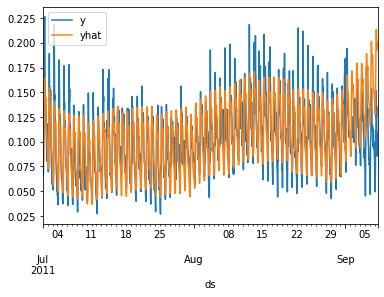

In [ ]:
# Plotting actual and predicted values together to check the difference
pd.concat([df_final.set_index('ds')['y'], forecast.set_index('ds')['yhat']], axis=1).plot()

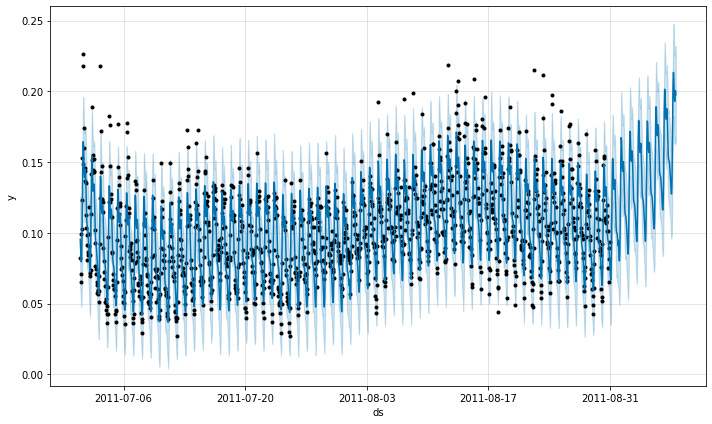

In [ ]:
fig1 = model.plot(forecast)

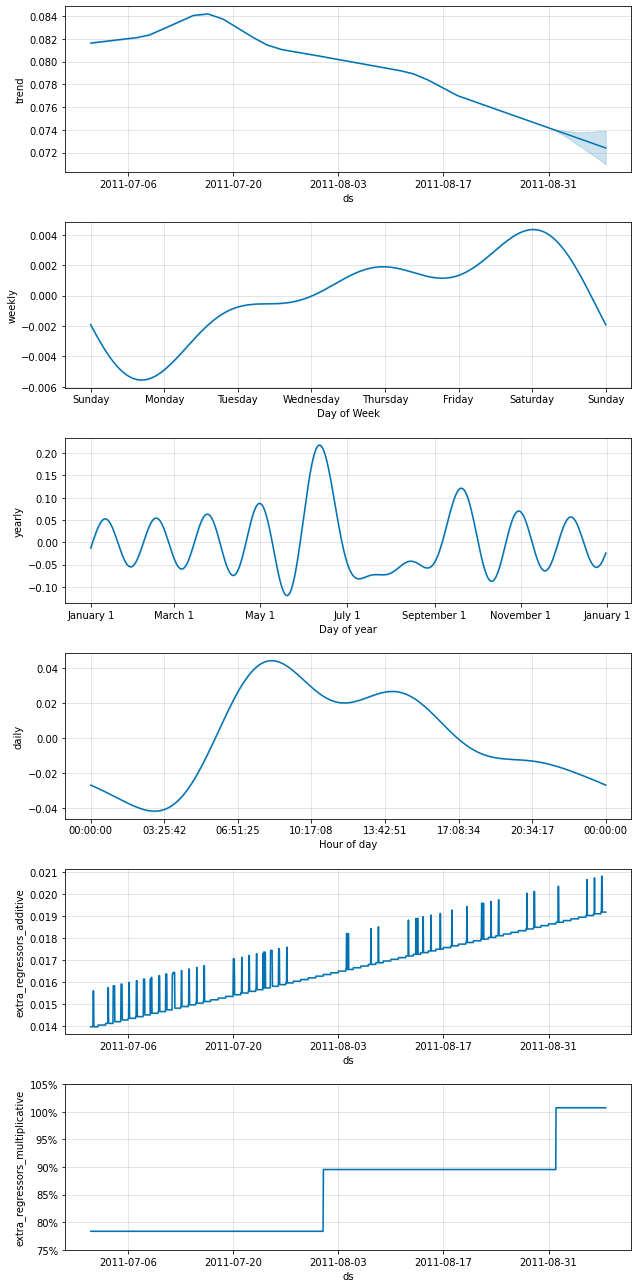

In [ ]:
fig2 = model.plot_components(forecast)

Cross Validation

In [ ]:
from prophet.diagnostics import cross_validation, performance_metrics
cv_results = cross_validation(model = model, initial = '916 hours', horizon = '183 hours')
df_p = performance_metrics(cv_results)

INFO:prophet:Making 4 forecasts with cutoffs between 2011-08-11 22:30:00 and 2011-08-23 09:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpccort99c/j3yg7mcv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpccort99c/s72xihak.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58070', 'data', 'file=/tmp/tmpccort99c/j3yg7mcv.json', 'init=/tmp/tmpccort99c/s72xihak.json', 'output', 'file=/tmp/tmp_mbcuv5y/prophet_model-20220918125459.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:54:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:55:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpccort99c/daud4vuo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpccort99c/kx35gw2r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-pack

In [ ]:
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 18:30:00,0.000268,0.016374,0.011806,0.104078,0.075586,0.104345,0.945205
1,0 days 19:00:00,0.000266,0.016297,0.011709,0.103583,0.073404,0.103789,0.945205
2,0 days 19:30:00,0.000258,0.016073,0.011449,0.101807,0.073139,0.101923,0.945205
3,0 days 20:00:00,0.000275,0.016574,0.011805,0.103440,0.073404,0.103868,0.931507
4,0 days 20:30:00,0.000302,0.017364,0.012459,0.108257,0.081131,0.109160,0.917808
...,...,...,...,...,...,...,...,...
325,7 days 13:00:00,0.002426,0.049259,0.040070,0.378875,0.423473,0.509075,0.452055
326,7 days 13:30:00,0.002561,0.050606,0.041395,0.392778,0.425393,0.537306,0.438356
327,7 days 14:00:00,0.002553,0.050522,0.041355,0.391205,0.423473,0.533903,0.438356
328,7 days 14:30:00,0.002758,0.052512,0.042906,0.403462,0.425393,0.559270,0.424658


/usr/local/lib/python3.7/dist-packages/prophet/plot.py:544: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.

/usr/local/lib/python3.7/dist-packages/prophet/plot.py:545: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.



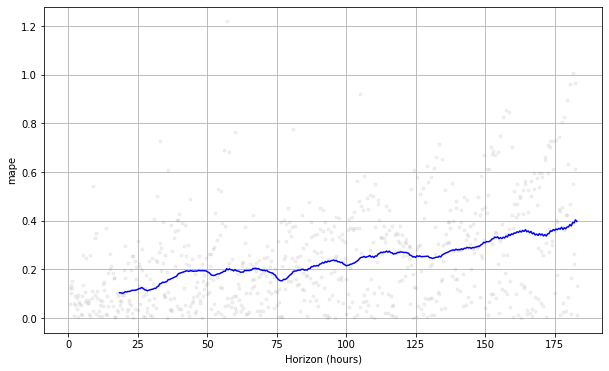

In [ ]:
# Plotting the corss validation metrics
from prophet.plot import plot_cross_validation_metric
fig3 = plot_cross_validation_metric(cv_results, metric='mape')

Detecting Anomalies

In [ ]:
# Concatinating the Original and Forecasted Dataframes
result = pd.concat([df_final[['ds', 'y']], forecast[['yhat', 'yhat_lower', 'yhat_upper']]], axis=1)
result['error'] = result['y'] - result['yhat']
result['uncertainty'] = result['yhat_upper'] - result['yhat_lower']
result

,ds,y,yhat,yhat_lower,yhat_upper,error,uncertainty
0,2011-07-01 00:00:00,0.081965,0.095440,0.061795,0.125739,-0.013476,0.063944
1,2011-07-01 01:00:00,0.098972,0.089232,0.057544,0.119782,0.009740,0.062238
2,2011-07-01 02:00:00,0.065314,0.082826,0.051985,0.113853,-0.017512,0.061869
3,2011-07-01 03:00:00,0.070663,0.079461,0.047724,0.109995,-0.008798,0.062271
4,2011-07-01 04:00:00,0.102490,0.084377,0.053256,0.116714,0.018113,0.063458
...,...,...,...,...,...,...,...
1643,2011-09-07 11:00:00,0.094662,0.194851,0.163252,0.226650,-0.100188,0.063398
1644,2011-09-07 12:00:00,0.097657,0.192848,0.163964,0.225074,-0.095192,0.061110
1645,2011-09-07 13:00:00,0.096201,0.196892,0.161876,0.228125,-0.100691,0.066249
1646,2011-09-07 14:00:00,0.085386,0.200424,0.167179,0.232360,-0.115037,0.065180


In [ ]:
import numpy as np
# Here if the absolute of the error is found to be greater 
# than the uncertainty then we consider it as an anomaly
result['anomaly'] = result.apply(lambda x: 
          'Yes' if(np.abs(x['error']) > x['uncertainty']) else 'No', axis = 1)
result

,ds,y,yhat,yhat_lower,yhat_upper,error,uncertainty,anomaly
0,2011-07-01 00:00:00,0.081965,0.095440,0.061795,0.125739,-0.013476,0.063944,No
1,2011-07-01 01:00:00,0.098972,0.089232,0.057544,0.119782,0.009740,0.062238,No
2,2011-07-01 02:00:00,0.065314,0.082826,0.051985,0.113853,-0.017512,0.061869,No
3,2011-07-01 03:00:00,0.070663,0.079461,0.047724,0.109995,-0.008798,0.062271,No
4,2011-07-01 04:00:00,0.102490,0.084377,0.053256,0.116714,0.018113,0.063458,No
...,...,...,...,...,...,...,...,...
1643,2011-09-07 11:00:00,0.094662,0.194851,0.163252,0.226650,-0.100188,0.063398,Yes
1644,2011-09-07 12:00:00,0.097657,0.192848,0.163964,0.225074,-0.095192,0.061110,Yes
1645,2011-09-07 13:00:00,0.096201,0.196892,0.161876,0.228125,-0.100691,0.066249,Yes
1646,2011-09-07 14:00:00,0.085386,0.200424,0.167179,0.232360,-0.115037,0.065180,Yes


In [ ]:
# Visualing the data using plotly
fig = px.scatter(result, x='ds', y='y', color='anomaly', title='Real Ad Exchange')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector = dict(
        buttons=list([
                      dict(count=1, label="1y", step="year", stepmode="backward"),
                      dict(count=2, label="3y", step="year", stepmode="backward"),
                      dict(count=3, label="5y", step="year", stepmode="backward"),
                      dict(step="all")
        ])
    )
)

fig.show()